# Tutorial on dimension reduction and text mining

This tutorial covers the following issues:
* What is text data?
* How to do machine learning with the text data?
* What is bag-of-words model?
* What are TF-IDF features generated from texts?
* How to apply linear dimension reduction techniques e.g. PCA?
* How to apply nonlinear dimension reduction techniques e.g. tSNE?

More information (some of the ideas from these sources are used during this seminar) are at
* http://scikit-learn.org/stable/datasets/twenty_newsgroups.html - newsgroups dataset
* http://blog.applied.ai/visualising-high-dimensional-data/ - PCA and tSNE tutorial
* https://github.com/udsclub/ucu_sentiment - course on sentiment analysis

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.linear_model import logistic

%matplotlib inline

In [12]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import scipy.sparse as sparse

## Load 20newsgroup dataset

We are going to work with the *20newsgroup* dataset. It consists of numerous message from newsgroups that fall into 20 different categories.
This dataset is available from *sklearn* library.
See also the original page for this dataset http://qwone.com/~jason/20Newsgroups/

Our final goal is to construct classifier that can distinguish between topics of the mail on the base of its content.
Moreover, we want for our model to be able to generalize well i.e. it should work well for texts outside of the corpus.

In [13]:
# dataset is from http://people.csail.mit.edu/jrennie/20Newsgroups/20news-bydate.tar.gz
# it contains messages from newsgroups 
# to load it using a single command execute:
# from sklearn.datasets import fetch_20newsgroups
# newsgroups_train = fetch_20newsgroups(subset='train')

newsgroups_training = fetch_20newsgroups(subset='train', data_home='data', download_if_missing=False)

In [14]:
# there are 20 categories in the dataset
from pprint import pprint
pprint(list(newsgroups_training.target_names))
print('Number of categories is %d' % len(list(newsgroups_training.target_names)))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
Number of categories is 20


In [15]:
newsgroups_training.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [16]:
newsgroups_training['filenames']

array(['data\\20news_home\\20news-bydate-train\\rec.autos\\102994',
       'data\\20news_home\\20news-bydate-train\\comp.sys.mac.hardware\\51861',
       'data\\20news_home\\20news-bydate-train\\comp.sys.mac.hardware\\51879',
       ...,
       'data\\20news_home\\20news-bydate-train\\comp.sys.ibm.pc.hardware\\60695',
       'data\\20news_home\\20news-bydate-train\\comp.graphics\\38319',
       'data\\20news_home\\20news-bydate-train\\rec.motorcycles\\104440'],
      dtype='<U67')

In [17]:
# an example of a message
index = 300
print(newsgroups_training['data'][index])
print(newsgroups_training['target_names'][newsgroups_training['target'][index]])

From: jae2001@andy.bgsu.edu (Jason Ehas)
Subject: Re: Giveaways
Organization: Home of 1984 NCAA hockey champs
Lines: 43

In article <1qi44l$kqr@access.digex.net>, steveg@cadkey.com (Steve
Gallichio) wrote:
> 
> 
> John P. Curcio (jpc@philabs.philips.com) responded to my drivel:
> 
> >steveg@cadkey.com (Steve Gallichio) writes:
> > 
> >>I still am surprised that no one has tried giving away the goodies at the end
> >>of the game. The two problems with that, of course, are that you would want
> >>to make sure the first people in the building would be assured of getting
> >>them (probably redeemable vouchers), and that the building managers want to
> >>avoid at all costs delaying people as they leave the building, if, for
> >>instance, the goodies are given to people as they exit.
> >
> >I went to the New Jersey Devils/Carvel Ice Cream Puck Night (tm) last year to
> >see the beloved Bruins play.  The pucks were given out at the end of the game.
> >I could just imagine what would have happ

# Short intro on text mining

To be able to apply a machine learning algorithm in the text mining area we need to generate numerical features.

## Bag of words model

The following assumptions are used in bag-of-words model:
* Order of words doesn't matter
* What matters is what words (or tokens) are in a document and how many of them are in a document
* More often occurences of word mean that the word is more important for classification of a document

Basically, we want to count number of occurences of each word and then identify the most important ones.
If we use *sklearn* buildins we get sparse matrices, as it is usually to have very large number of zeros for big corpuses.

In [19]:
first_sentence = 'Happy families are all alike alike'
second_sentence = 'In our research, happy families use humor a lot'
count_vectorizer = CountVectorizer()

result = count_vectorizer.fit_transform(raw_documents=[first_sentence, second_sentence])
words_dataframe = pd.DataFrame(result.todense(), columns=count_vectorizer.get_feature_names(), index=[1, 2])
words_dataframe

,alike,all,are,families,happy,humor,in,lot,our,research,use
1,2,1,1,1,1,0,0,0,0,0,0
2,0,0,0,1,1,1,1,1,1,1,1


## TF-IDF defintion
In TF-IDF approach (term frequency - inverse document frequency), in addition to usual BoW-model, the following augmentation is made:
* Order of words doesn't matter
* What matters is what words (or tokens) are in a document and how many of them are in a document
* More often occurences of word mean that the word is more important for classification of a document
* **If a word (or a token) appears in a document and rarely appears in other documents - it is important. **
* **The opposite also holds: if it's common across most documents - then this word doesn't help us distinquishing documents**

Let us define TF-IDF features:

$$  
    TF(w,T)=n_{Tw} \\ 
    IDF(w, T)= log{\frac{N}{n_{w}}} \\
    TF\text{-}IDF(w, T) = n_{Tw}\ log{\frac{N}{n_{w}}}
$$

Here
* $T$ corresponds to a document, 
* $w$ - selected word (or token) in the document $T$, 
* $n_{Tw}$ - number of occurences of $w$ in text $T$, 
* $n_{w}$ - number of documents, containing word $w$, 
* $N$ - total number of documents in the corpus.

In a similar way we obtain very sparse matrices of features.


In [20]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_result = tf_idf_vectorizer.fit_transform(raw_documents=[first_sentence, second_sentence])
words_dataframe = pd.DataFrame(tf_idf_result.todense(), columns=tf_idf_vectorizer.get_feature_names(), index=[1, 2])
words_dataframe

,alike,all,are,families,happy,humor,in,lot,our,research,use
1,0.755256,0.377628,0.377628,0.268685,0.268685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.268685,0.268685,0.377628,0.377628,0.377628,0.377628,0.377628,0.377628


## Get TF-IDF features

In [23]:
# Load only a part of the data
selected_categories = ['alt.atheism', 'comp.graphics', 
                       'sci.space', 'talk.religion.misc']
newsgroups_training = fetch_20newsgroups(subset='train', data_home='data',
                                         categories=selected_categories, 
                                         download_if_missing=False)
newsgroups_test = fetch_20newsgroups(subset='test', data_home='data',
                                     categories=selected_categories, 
                                     download_if_missing=False)

In [22]:
vectorizer = TfidfVectorizer()
training_vectors = vectorizer.fit_transform(newsgroups_training.data)
print(training_vectors.shape)
print(training_vectors.nnz / float(training_vectors.shape[0])) # average number of non-zero features

test_vectors = vectorizer.transform(newsgroups_test.data)
print(test_vectors.shape)
print(test_vectors.nnz / float(test_vectors.shape[0])) # average number of non-zero features

(2034, 34118)
159.0132743362832
(1353, 34118)
155.1478196600148


## Train Logistic regression classifier

In [24]:
# classifier = MultinomialNB(alpha=0.01)
classifier = logistic.LogisticRegression(C=1e5)
classifier.fit(training_vectors, newsgroups_training.target)

training_predictions = classifier.predict(training_vectors)
test_predictions = classifier.predict(test_vectors)
print('Training F1 score: %.4f' % f1_score(newsgroups_training.target, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(newsgroups_test.target, test_predictions, average='macro'))

Training F1 score: 1.0000
Test F1 score: 0.8766


Results indicate significant overfitting

In [25]:
# show the most informative features
def show_top_features(classifier, vectorizer, categories, top_number=10, return_features=False):
    feature_names = np.asarray(vectorizer.get_feature_names())
    if return_features:
        features_to_return = set()
    for category_index, category in enumerate(categories):
        top_features = np.argsort(classifier.coef_[category_index])[-top_number:]
        if return_features:
            features_to_return = features_to_return.union(top_features)
        else:
            print("%s: %s" % (category, "; ".join(feature_names[top_features])))
    if return_features:
        return features_to_return        

In [26]:
show_top_features(classifier, vectorizer, selected_categories, top_number=10)

alt.atheism: okcforum; wingate; caltech; enviroleague; edu; islamic; cobb; atheists; atheism; keith
comp.graphics: computer; files; 3do; animation; 3d; points; 42; file; image; graphics
sci.space: pat; nick; alaska; sci; launch; nasa; dc; moon; orbit; space
talk.religion.misc: morality; 2000; buffalo; fbi; frank; who; mr; hudson; beast; christian


There are some problems with the results:
* Almost every group is distinguished by whether headers such as NNTP-Posting-Host: and Distribution: appear more or less often.
* Another significant feature involves whether the sender is affiliated with a university, as indicated either by their headers or their signature.
* Other features match the names and e-mail addresses of particular people who were posting at the time.

# Load data without some information that lead to overfitting and train a classifier again

In [15]:
newsgroups_training = fetch_20newsgroups(subset='train', 
                                         remove=('headers', 'footers', 'quotes'),
                                         categories=selected_categories, 
                                         download_if_missing=False)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=selected_categories, 
                                     download_if_missing=False)

In [16]:
vectorizer = TfidfVectorizer()
training_vectors = vectorizer.fit_transform(newsgroups_training.data)
print(training_vectors.shape)
print(training_vectors.nnz / float(training_vectors.shape[0])) # average number of non-zero features

test_vectors = vectorizer.transform(newsgroups_test.data)
print(test_vectors.shape)
print(test_vectors.nnz / float(test_vectors.shape[0])) # average number of non-zero features

(2034, 26879)
96.70599803343165
(1353, 26879)
95.73762010347376


In [17]:
# classifier = MultinomialNB(alpha=0.01)
classifier = logistic.LogisticRegression(C=1e5)
classifier.fit(training_vectors, newsgroups_training.target)

training_predictions = classifier.predict(training_vectors)
test_predictions = classifier.predict(test_vectors)
print('Training F1 score: %.4f' % f1_score(newsgroups_training.target, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(newsgroups_test.target, test_predictions, average='macro'))

Training F1 score: 0.9789
Test F1 score: 0.7588


In [18]:
show_top_features(classifier, vectorizer, selected_categories, top_number=10)

alt.atheism: enviroleague; nanci; islam; motto; atheist; religion; bobby; matthew; atheists; atheism
comp.graphics: 3do; hi; 42; sgi; points; file; 3d; computer; image; graphics
sci.space: shuttle; nick; allen; moon; mars; spacecraft; launch; nasa; orbit; space
talk.religion.misc: koresh; ekr; terrorist; christ; hudson; order; christians; fbi; blood; christian


### Now we use only top features to further reduce the dimension of the data

In [27]:
top_features = show_top_features(classifier, vectorizer, 
                                 selected_categories, top_number=500, return_features=True)
top_features = [x for x in top_features] # transform from a set to a list
print(len(top_features)) 

1967


In [28]:
selected_training_vectors = training_vectors[:, top_features]
selected_test_vectors = test_vectors[:, top_features]

In [29]:
# classifier = MultinomialNB(alpha=0.01)
classifier = logistic.LogisticRegression(C=1e5)
classifier.fit(selected_training_vectors, newsgroups_training.target)

training_predictions = classifier.predict(selected_training_vectors)
test_predictions = classifier.predict(selected_test_vectors)
print('Training F1 score: %.4f' % f1_score(newsgroups_training.target, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(newsgroups_test.target, test_predictions, average='macro'))

Training F1 score: 1.0000
Test F1 score: 0.8760


## Try to reduce dimensionality of the data

In [30]:
scaler = StandardScaler(with_mean=False).fit(selected_training_vectors)
scaled_training_vectors = scaler.transform(selected_training_vectors)
scaled_test_vectors = scaler.transform(selected_test_vectors)

In [31]:
print(scaled_training_vectors.shape)

(2034, 1967)


In [32]:
U, singular_values, singular_vectors = sparse.linalg.svds(scaled_training_vectors, 
                                                          k=992) # k is the number of singlar values to compute 

In [33]:
# sort singular vectors
sort_indexes = np.argsort(singular_values)[::-1]
singular_values = singular_values[sort_indexes]
U = U[:, sort_indexes]
singular_vectors = singular_vectors[sort_indexes, :]

0 singular values are NaN
0 singular values are less than 1e-12


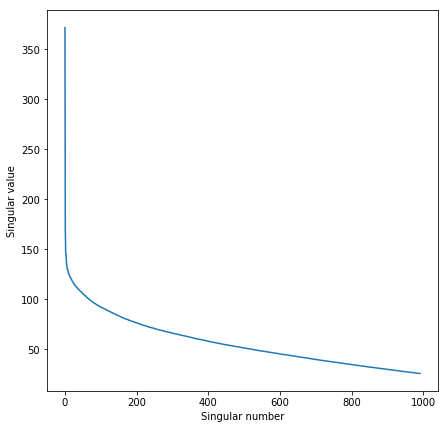

In [34]:
plt.figure(figsize=(7, 7))
plt.plot(singular_values)
plt.xlabel('Singular number')
plt.ylabel('Singular value')
print('{} singular values are NaN'.format(np.isnan(singular_values).sum()))
print('{} singular values are less than 1e-12'.format(len(singular_values[singular_values < 1e-12])))

Variance preserved by first 500 components == 77.73%
Variance preserved by first 100 components == 30.35%
Variance preserved by first 5 components == 3.16%


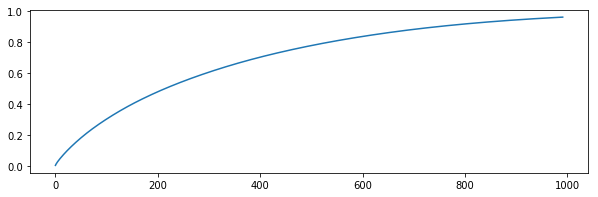

In [35]:
xtrans = np.dot(U, np.diag(singular_values))
explained_variance = np.var(xtrans, axis=0)
full_variance = np.array(np.mean(scaled_training_vectors.power(2), axis=0) - 
                         np.power(np.mean(scaled_training_vectors, axis=0), 2))
explained_variance_share = explained_variance / full_variance.sum()
ax = pd.Series(explained_variance_share.cumsum()).plot(kind='line', figsize=(10, 3))
print('Variance preserved by first 500 components == {:.2%}'.format(explained_variance_share.cumsum()[500]))
print('Variance preserved by first 100 components == {:.2%}'.format(explained_variance_share.cumsum()[100]))
print('Variance preserved by first 5 components == {:.2%}'.format(explained_variance_share.cumsum()[5]))

## Use truncated SVD to reduce dimensionality of data

In [36]:
number_of_components = 100
svd = TruncatedSVD(n_components=number_of_components)
svd_fit = svd.fit(scaled_training_vectors)
transformed_training_vectors = svd.fit_transform(scaled_training_vectors) 
transformed_test_vectors = svd.transform(scaled_test_vectors) 

In [37]:
# classifier = MultinomialNB(alpha=0.01)
classifier = logistic.LogisticRegression(C=1e5)
classifier.fit(transformed_training_vectors, newsgroups_training.target)

training_predictions = classifier.predict(transformed_training_vectors)
test_predictions = classifier.predict(transformed_test_vectors)
print('Training F1 score: %.4f' % f1_score(newsgroups_training.target, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(newsgroups_test.target, test_predictions, average='macro'))

Training F1 score: 0.9994
Test F1 score: 0.8445


### Quality is almost similar, while we significantly reduced the dimensionality of the data

In [50]:
number_of_components = 50
svd = TruncatedSVD(n_components=number_of_components)
svd_fit = svd.fit(scaled_training_vectors)
transformed_training_vectors = svd.fit_transform(scaled_training_vectors) 
transformed_test_vectors = svd.transform(scaled_test_vectors) 

In [51]:
training_dataframe = pd.DataFrame(transformed_training_vectors)
training_dataframe['target'] = newsgroups_training.target
training_dataframe['target'] = training_dataframe['target'].apply(lambda x: selected_categories[x])

In [44]:
training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 6 columns):
0         2034 non-null float64
1         2034 non-null float64
2         2034 non-null float64
3         2034 non-null float64
4         2034 non-null float64
target    2034 non-null object
dtypes: float64(5), object(1)
memory usage: 95.4+ KB


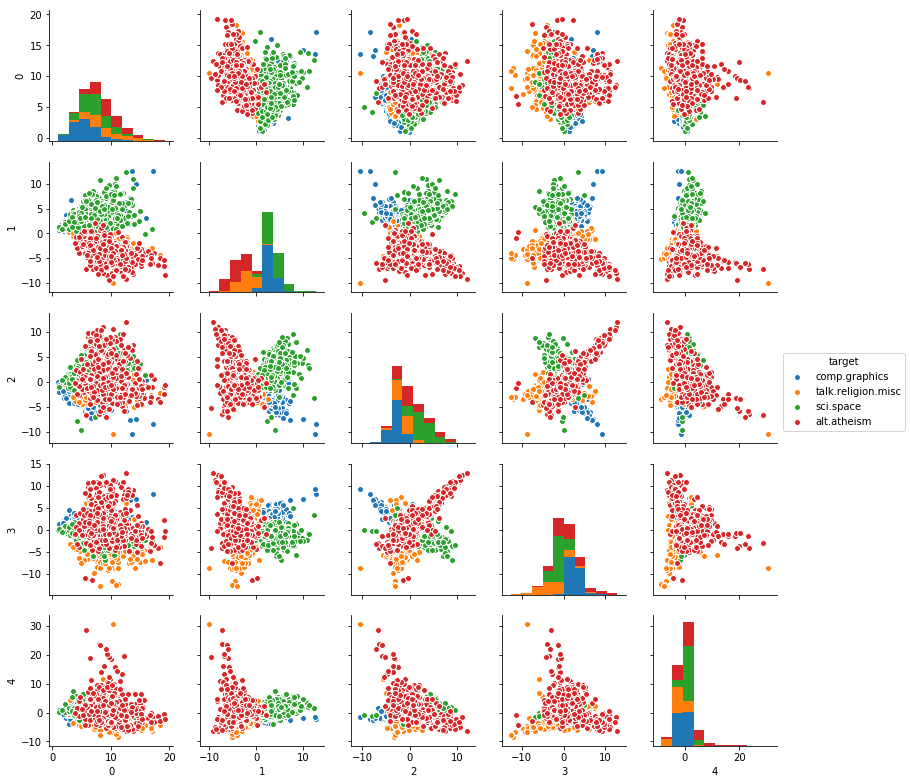

In [45]:
sns.pairplot(training_dataframe, hue='target', size=2.2)

We use the basic implementation available in scikit-learn with $O(n^2)$ complexity. This complexity is prohibitive for many real-world datasets. For real datasets you should use the Barnes-Hut implementation that is $O(n \log(n))$.

## Scaling time for TSNE

In [53]:
training_dataframe = pd.DataFrame(transformed_training_vectors)

In [54]:
training_dataframe.shape

(2034, 50)

C:\Users\a.zaytsev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


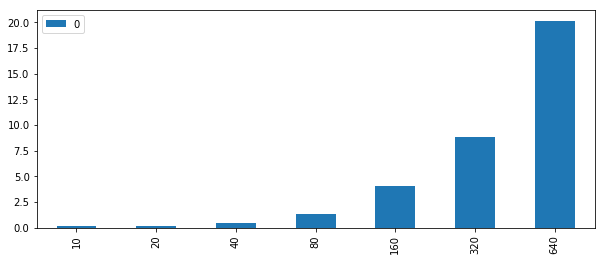

In [55]:
sample_size_list = [10, 20, 40, 80, 160, 320, 640]
tsne = TSNE(n_components=2, random_state=0)
run_time = np.empty((len(sample_size_list), 1))

for index, rows in enumerate(sample_size_list):
    start_time = time()
    Z = tsne.fit_transform(training_dataframe.iloc[:rows, :])
    run_time[index] = time() - start_time

pd.DataFrame(run_time, index=sample_size_list).plot(kind='bar', logy=False, figsize=(10, 4))

## Calculate t-SNE representation

In [56]:
tsne_training_data = tsne.fit_transform(training_dataframe)
tsne_training_dataframe = pd.DataFrame(tsne_training_data, columns=['x', 'y'])

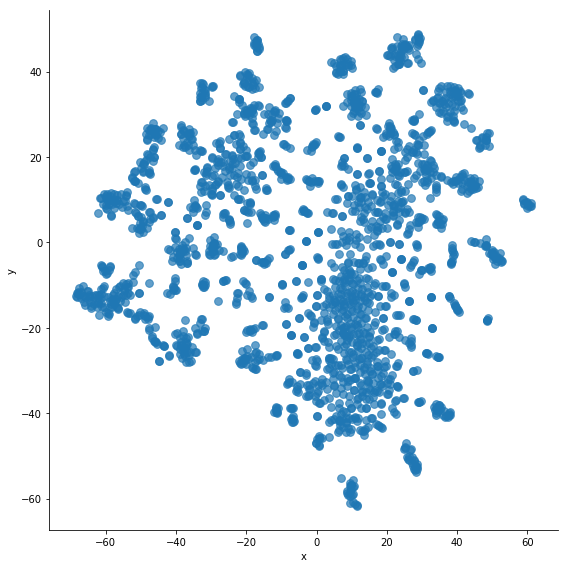

In [57]:
sns.lmplot('x', 'y', tsne_training_dataframe, fit_reg=False, 
           size=8, scatter_kws={'alpha' : 0.7, 's' : 60})

In [58]:
tsne_training_dataframe['target'] = newsgroups_training.target
tsne_training_dataframe['target'] = tsne_training_dataframe['target'].apply(lambda x: selected_categories[x])

Text(0.5,1,'Scatterplot of a 5D dataset reduced to 2D using t-SNE')

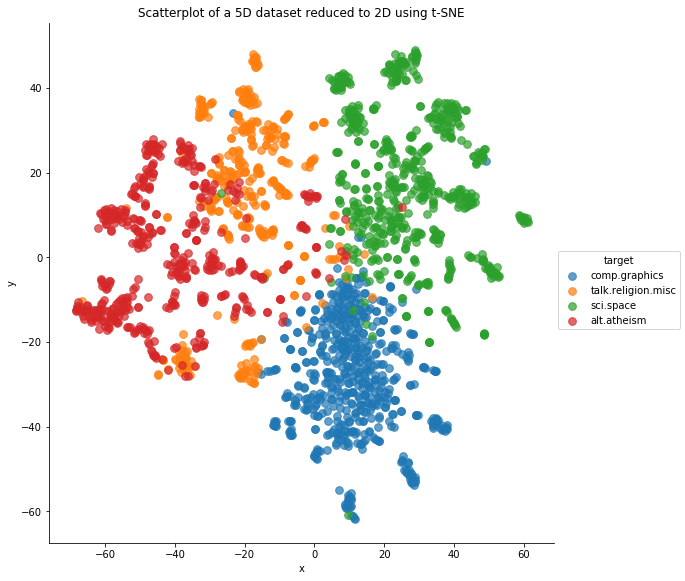

In [59]:
g = sns.lmplot('x', 'y', tsne_training_dataframe, hue='target', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 5D dataset reduced to 2D using t-SNE')

In [60]:
test_dataframe = pd.DataFrame(transformed_test_vectors)
tsne_test_data = tsne.fit_transform(test_dataframe)
tsne_test_dataframe = pd.DataFrame(tsne_test_data, columns=['x', 'y'])
tsne_test_dataframe['target'] = newsgroups_test.target
tsne_test_dataframe['target'] = tsne_test_dataframe['target'].apply(lambda x: selected_categories[x])

Text(0.5,1,'Scatterplot of a 5D dataset reduced to 2D using t-SNE')

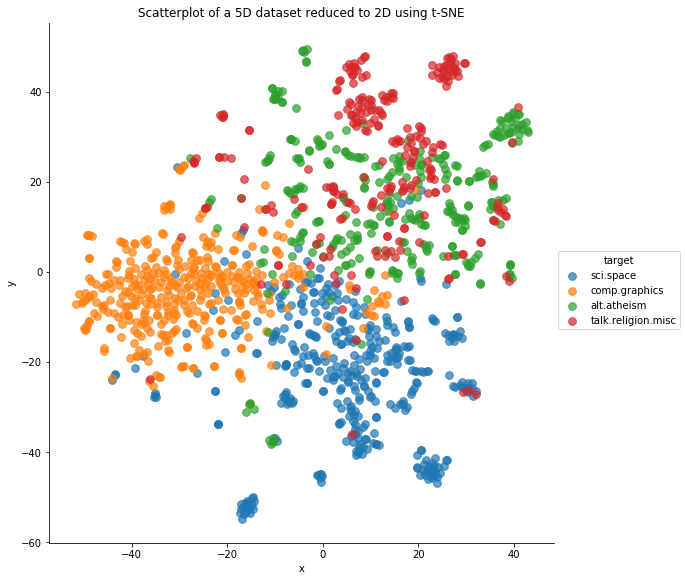

In [61]:
g = sns.lmplot('x', 'y', tsne_test_dataframe, hue='target', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 5D dataset reduced to 2D using t-SNE')